# Training a Classifier
This is it. You have seen how to define neural netowrks, compute loss and make updates to the wieghts of the network.

Now you might be thinking,
## What about data?
Generally, when you have to deal with image, text, audio or video data, you can use standard python packages
that load data into a numpy array. Then you can convert this array into a `torch.*Tensor`.
- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy, librosa
- For text either raw Python or Cython based loading, or NLTK and SpaCy are useful

Specifically for vision, we have created a package called `torchvision`, that has dataloaders for common datasets
such as ImageNet, CIFAR10, MNIST, etc. and data transformers for images, viz., `torchvision.datasets` and `torch.utils.data.DataLoader`.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial we will use the CIFAR10 dataset. It has classes: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', frog', 'horse', 'ship', 'truck'. The images in CIFAR10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

## Training an image classifier
We will do following steps in order:
1. Load and normalize CIFAR10 training and test datasets using `torchvision`
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network

### 1. Load and normalize CIFAR10
using `torchvision`, it's extremely easy to load CIFAR10

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0,1]. We transform them to Tensors of normalized range [-1, 1].

NOTE: If running on Windows and you get BrokenPipeError, try setting the num_worker of `torch.utils.data.DataLoader() to 0

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
                                         shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some fo the training images for fun.

(3, 36, 138) (36, 138, 3)


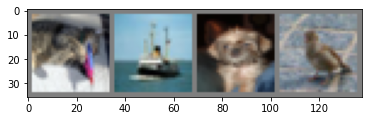

cat   ship  dog   bird 


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img /2 + 0.5 # denormalize
    npimg = img.numpy()
    print(npimg.shape, np.transpose(npimg, (1,2,0)).shape) # how to rehsape
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### 2. Define a Convolutional Neural Network
Copy the neural network from the Neural Networks section before and modify it to take 3-channel images
(instead of 1-channel images as is was defined)

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

### 3. Define a Loss function and optimizer
Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [11]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network
This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [12]:
for epoch in range(2): # loop over dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backwar + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
            
print('Finished training')

[1,  2000] loss: 2.217
[1,  4000] loss: 1.851
[1,  6000] loss: 1.674
[1,  8000] loss: 1.586
[1, 10000] loss: 1.552
[1, 12000] loss: 1.497
[2,  2000] loss: 1.419
[2,  4000] loss: 1.380
[2,  6000] loss: 1.389
[2,  8000] loss: 1.329
[2, 10000] loss: 1.329
[2, 12000] loss: 1.304
Finished training


Let's quickly ave our trained model:

In [13]:
path = './cifar_net.pth'
torch.save(net.state_dict(), path)

### 5. Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anyting at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('ground truth:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))